# Tarea 3 - Códigos del Trabajo de Investigación

## Physics-Informed Neural Network: Solución de un problema directo e inverso de Ecuaciones Diferenciales Parciales.

**Estadística Computacional**

**Nombre:** Sebastián Jara Cifuentes

**Curso:** Estadística Computacional

***Doctorado en Estadística***

### Herramientas

In [4]:
import sciann as sn
import numpy as np
import matplotlib.pyplot as plt 
from sciann.utils.math import diff, sign, sin
from mpl_toolkits.mplot3d import Axes3D

## Objetivo Principal

En este documento se resuelve la ecuación de Poisson para un problema directo e inverso, usando redes neuronales informadas por la física (PINN). 

## Problema Directo

Hallar $u=u(x,y)$ tal que: 

$$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = f(x,y)$$
$$u\vert_{\partial \Omega} = 0.$$

para $(x,y)\in [0,2]\times [0,2]$ y $f(x,y)=12(x^2 + y^2) - 24(x+y)$. 

La solución exacta de la EDP anterior es conocida, y viene dada por 
$$u(x,y)= 6xy(x-2)(y-2).$$ 




/var/folders/d8/cy3sy03s43z0px__bdyh_rmc0000gn/T/ipykernel_80960/399946637.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes3d = Axes3D(fig)


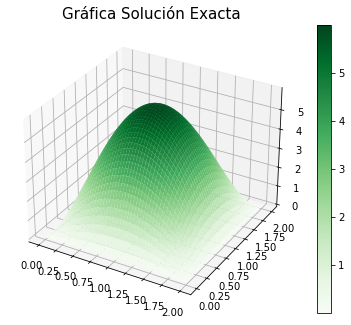

In [93]:
#Gráfica Solución Exacta

x_data, y_data = np.meshgrid(
                            np.linspace(0, 2, 100), 
                            np.linspace(0, 2, 100)
                            )

u_data = 6*(x_data)*(y_data)*(x_data-2)*(y_data-2)

# Dibujar superficie 3D

fig = plt.figure()
axes3d = Axes3D(fig)
plt.title(r'Gráfica Solución Exacta', fontsize=15)
surf = axes3d.plot_surface(x_data,y_data,u_data, cmap='Greens')
fig.colorbar(surf, ax=axes3d)
plt.grid()
plt.savefig("Gráfica de Solución Exacta 1")
plt.show()

## Solución Numérica Problema Directo mediante PINN

**Configuración de la Red Neuronal**

In [50]:
#Entradas Salidas
x = sn.Variable('x')
y = sn.Variable('y')
u = sn.Field('u')

#Configuracion Red Neuronal
u = sn.Functional('u',[x,y], [10,10], 'tanh')

**Configuración Función de Pérdida**

$$L(\theta) =  \dfrac{1}{N_b}\sum\limits_{j=1}^{N_b} |u(t_b^{j},x_b^{j}) - \hat{u}(x_b^{j},y_b^{j}, \theta) |^2 
+ \dfrac{1}{N_i}\sum\limits_{j=1}^{N_i} \left| \dfrac{\partial^2 \hat{u}(x_i^{j},y_i^{j}, \theta)}{\partial x^2} + \dfrac{\partial^2 \hat{u}(x_i^{j},y_i^{j}, \theta)}{\partial y^2} - f(x_i^{j},y_i^{j}) \right|^2, $$

In [51]:
#Restricción Física

L1 = diff(u, x, order =2) + diff(u, y, order =2) - 12*(x**2 + y**2) + 24*(x + y) 

#Condiciones de Borde

L2 = ( x == 0 ) * (u - 0)
L3 = ( x == 2 ) * (u - 0)
L4 = ( y == 0 ) * (u - 0)
L5 = ( y == 2 ) * (u - 0)

#Modelo Para entrenar
m = sn.SciModel([x, y], [L1, L2, L3, L4, L5], "mse", "Adam")

**Entrenamiento**

In [52]:
#punto de Entrenamiento

x_train, y_train = np.meshgrid( 
                            np.linspace(0, 2, 100), 
                            np.linspace(0, 2, 100)
                            )

#Inicialción y configuración del Entrenamiento
h = m.train([x_train, y_train], 5*['zero'], learning_rate=0.002, epochs=10000, verbose=0)


Total samples: 10000 
Batch size: 64 
Total batches: 157 


Epoch 08596: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.


/var/folders/d8/cy3sy03s43z0px__bdyh_rmc0000gn/T/ipykernel_80960/3070547767.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes3d = Axes3D(fig)


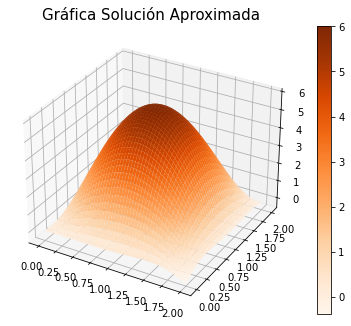

In [67]:
#Gráfica Solución Aproximada mediante Red Neuronal

u_pred = u.eval([x_data, y_data])


fig = plt.figure()
axes3d = Axes3D(fig)
plt.title(r'Gráfica Solución Aproximada', fontsize=15)
surf = axes3d.plot_surface(x_data, y_data, u_pred, cmap='Oranges')
fig.colorbar(surf, ax=axes3d)
plt.grid()
plt.savefig("Gráfica de Solución Aproximada 1")
plt.show()



**Desempeño**

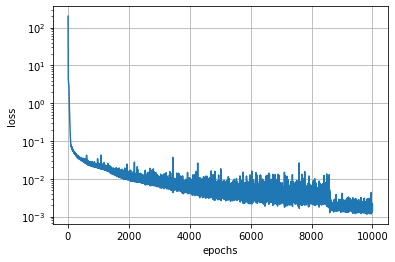

In [68]:
#Gráfica Función de Pérdida

plt.semilogy(h.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.savefig("Loss 1")
plt.show()

In [69]:
#Cálculo Error L2

Error = np.abs(u_data - u_pred)
ErrorL2 = np.sqrt(np.mean(Error**Error))
print('El error L2 es:', ErrorL2)

El error L2 es: 0.9666571624648286


## Problema Inverso

Conocida $u=u(x,y)$, hallar $\lambda$ tal que: 


$$\dfrac{\partial^2 u}{\partial x^2} + \lambda \dfrac{\partial^2 u}{\partial y^2} = f(x,y)$$ 
      $$ u\vert_{\partial \Omega} = 0. $$


para $(x,y)\in [0,2]\times [0,2]$ y $f(x,y)=12(x^2 + y^2) - 24(x+y)$. 

En esta caso, elegimos $u(x,y)= 6xy(x-2)(y-2)$, entonces el valor exacto de $\lambda$ en la EDP anterior es 1.


## Solución Numérica Problema inverso mediante PINN

**Configuración de la Red Neuronal**

In [96]:
#Entradas Salidas
x = sn.Variable('x')
y = sn.Variable('y')
u = sn.Field('u')
lamb = sn.Parameter(0.0, inputs = [x, y], name= 'lamb') #Def. parámetro entrenable lambda

#Configuracion Red Neuronal
u = sn.Functional('u',[x,y], [10,10], 'tanh')

**Configuración Función de Pérdida**



$$L(\theta, \lambda) =  \dfrac{1}{N_i}\sum\limits_{j=1}^{N_i} |u(t_i^{j},x_i^{j}) - \hat{u}(x_i^{j},y_i^{j}, \theta)|^2  
+ \dfrac{1}{N_i}\sum\limits_{j=1}^{N_i} \left| \dfrac{\partial^2 \hat{u}(x_i^{j},y_i^{j}, \theta)}{\partial x^2} + \lambda\, \dfrac{\partial^2 \hat{u}(x_i^{j},y_i^{j}, \theta)}{\partial y^2} - f(x_i^{j},y_i^{j}) \right|^2. $$

In [97]:
#Restricción Física

L1 = diff(u, x, order =2) + lamb*diff(u, y, order =2) - 12*(x**2 + y**2) + 24*(x + y) 

#Condiciones de Borde

L2 = u

#Modelo Para entrenar
m = sn.SciModel([x, y], [L1, L2], "mse", "Adam")

**Entrenamiento**

In [98]:
#punto de Entrenamiento

x_train, y_train = np.meshgrid( 
                            np.linspace(0, 2, 100), 
                            np.linspace(0, 2, 100)
                            )

#Inicialción y configuración del Entrenamiento
h = m.train([x_train, y_train], ['zero', u_data], learning_rate=0.002, epochs=1000, verbose=0)


Total samples: 10000 
Batch size: 64 
Total batches: 157 



/var/folders/d8/cy3sy03s43z0px__bdyh_rmc0000gn/T/ipykernel_80960/3771078191.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes3d = Axes3D(fig)


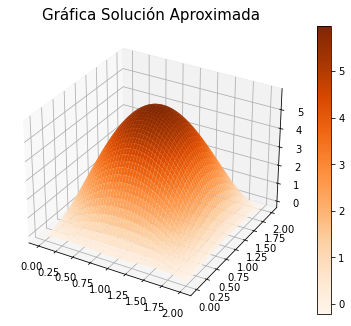

In [100]:
#Gráfica Solución Aproximada mediante Red Neuronal

u_pred = u.eval(m,[x_data, y_data])


fig = plt.figure()
axes3d = Axes3D(fig)
plt.title(r'Gráfica Solución Aproximada', fontsize=15)
surf = axes3d.plot_surface(x_data, y_data, u_pred, cmap='Oranges')
fig.colorbar(surf, ax=axes3d)
plt.grid()
plt.savefig("Gráfica de Solución Aproximada 2")
plt.show()


**Desempeño**

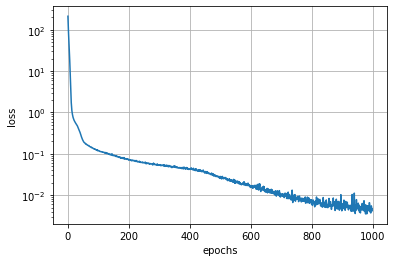

In [108]:
#Gráfica Función de Pérdida

plt.semilogy(h.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.savefig("Loss 2")
plt.show()

In [105]:
#Cálculo Error L2

Error = np.abs(u_data - u_pred)
ErrorL2 = np.sqrt(np.mean(Error**Error))
print('El error L2 es:', ErrorL2)

El error L2 es: 0.9608973802228709


In [106]:
#Valor del Parámetro Lambda estimado

Lamb = lamb.value
print('El valor del lambda estimado es:', Lamb)

El valor del lambda estimado es: [1.005846]


In [107]:
1.005846-1

0.005846000000000018